<a href="https://colab.research.google.com/github/YthanW/STATS507-Fall2025/blob/main/arima_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import autogluon.timeseries as ag_ts
import chronos
from importlib.metadata import version

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("AutoGluon TimeSeries:", ag_ts.__version__)
print("Chronos-forecasting:", version("chronos-forecasting"))


d:\anaconda3\envs\ag311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 2.5.1
CUDA available: True
AutoGluon TimeSeries: 1.2
Chronos-forecasting: 1.5.3


In [37]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display
# AutoGluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [3]:
# ========= 50 US large-cap tickers =========
TICKERS = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN",
    "META", "AVGO", "TSLA", "BRK-B", "LLY",
    "JPM", "JNJ", "XOM", "UNH", "V",
    "WMT", "PG", "MA", "HD", "COST",
    "PEP", "ABBV", "MRK", "CRM", "ORCL",
    "ADBE", "CSCO", "TMO", "ACN", "MCD",
    "DHR", "ABT", "KO", "AMD", "BAC",
    "PFE", "NFLX", "INTU", "LIN", "TXN",
    "CAT", "LRCX", "IBM", "QCOM", "CVS",
    "NKE", "UPS", "HON", "LOW", "AMAT",
]


def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    If columns are a MultiIndex (e.g. ('Adj Close', 'AAPL')), keep only level-0.
    """
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = [c[0] for c in df.columns]
    return df


def pick_price_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pick a reasonable price column from a yfinance DataFrame.
    Preference order: 'Adj Close' -> 'Close' -> 'Open'.
    Returns a single-column DataFrame named 'price'.
    """
    for col in ["Adj Close", "Close", "Open"]:
        if col in df.columns:
            return df[[col]].rename(columns={col: "price"})
    raise KeyError(f"No usable price column found in columns: {df.columns.tolist()}")


def download_multi_stock_data(
    tickers,
    start: str = "2015-01-01",
    end: str | None = None,
) -> pd.DataFrame:
    """
    Download daily prices for multiple tickers using yfinance and compute log returns.

    Returns long-format DataFrame:
        ['date', 'ticker', 'price', 'log_return'].
    """
    all_list = []
    failed = []

    for t in tickers:
        print(f"Downloading {t} ...")
        df = yf.download(t, start=start, end=end, progress=False)
        if df.empty:
            print(f"[WARN] Empty data for {t}, skipped.")
            failed.append(t)
            continue

        df = flatten_columns(df)

        try:
            px = pick_price_column(df)
        except Exception as e:
            print(f"[WARN] {t}: {e} -> skipped.")
            failed.append(t)
            continue

        # Compute log returns of the selected price
        px["log_return"] = np.log(px["price"]).diff()
        px = px.dropna(subset=["log_return"])

        # Attach ticker and date columns
        px["ticker"] = t
        px = px.reset_index().rename(columns={"Date": "date"})
        all_list.append(px)

    if not all_list:
        raise ValueError("No valid tickers downloaded.")

    full = pd.concat(all_list, ignore_index=True)
    full = full.sort_values(["ticker", "date"]).reset_index(drop=True)

    print("Failed tickers:", failed)
    return full

In [4]:
# ---- dataset download ----
data_long = download_multi_stock_data(TICKERS, start="2015-01-01")
print("========== Data Overview ==========")
print("Data shape:", data_long.shape)
print(data_long.head())

Failed tickers: []
========== Data Overview ==========
Data shape: (137400, 4)
        date      price  log_return ticker
0 2015-01-05  23.554743   -0.028576   AAPL
1 2015-01-06  23.556959    0.000094   AAPL
2 2015-01-07  23.887276    0.013925   AAPL
3 2015-01-08  24.805079    0.037702   AAPL
4 2015-01-09  24.831686    0.001072   AAPL


In [5]:

# ======================
# Train / Test
# ======================
def time_based_train_test_split(df_long: pd.DataFrame, test_frac: float = 0.2):
    """
    Split the long-format dataset into train/test sets by DATE.
    All tickers share the same cutoff_date.
    """
    unique_dates = np.sort(df_long["date"].unique())
    n_dates = len(unique_dates)

    cutoff_idx = int((1 - test_frac) * n_dates)
    cutoff_date = unique_dates[cutoff_idx]

    train = df_long[df_long["date"] <= cutoff_date].copy()
    test = df_long[df_long["date"] > cutoff_date].copy()

    return train, test, cutoff_date


train_df, test_df, cutoff_date = time_based_train_test_split(
    data_long, test_frac=0.2
)

print("\n========== Train/Test Split ==========")
print("Cutoff date:", cutoff_date)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train date range:", train_df["date"].min(), "→", train_df["date"].max())
print("Test date range:", test_df["date"].min(), "→", test_df["date"].max())

print("\nTrain samples per ticker:")
print(train_df.groupby("ticker")["date"].count())

print("\nTest samples per ticker:")
print(test_df.groupby("ticker")["date"].count())


========== Train/Test Split ==========
Cutoff date: 2023-09-28T00:00:00.000000000
Train shape: (109950, 4)
Test shape: (27450, 4)
Train date range: 2015-01-05 00:00:00 → 2023-09-28 00:00:00
Test date range: 2023-09-29 00:00:00 → 2025-12-05 00:00:00

Train samples per ticker:
ticker
AAPL     2199
ABBV     2199
ABT      2199
ACN      2199
ADBE     2199
AMAT     2199
AMD      2199
AMZN     2199
AVGO     2199
BAC      2199
BRK-B    2199
CAT      2199
COST     2199
CRM      2199
CSCO     2199
CVS      2199
DHR      2199
GOOGL    2199
HD       2199
HON      2199
IBM      2199
INTU     2199
JNJ      2199
JPM      2199
KO       2199
LIN      2199
LLY      2199
LOW      2199
LRCX     2199
MA       2199
MCD      2199
META     2199
MRK      2199
MSFT     2199
NFLX     2199
NKE      2199
NVDA     2199
ORCL     2199
PEP      2199
PFE      2199
PG       2199
QCOM     2199
TMO      2199
TSLA     2199
TXN      2199
UNH      2199
UPS      2199
V        2199
WMT      2199
XOM      2199
Name: date, dtyp

In [6]:
# ======================
# Switch & save directory
# ======================
TRAIN_ARIMA_5   = True
TRAIN_CHRONOS_5 = True
TRAIN_CHRONOS_60 = True
BASE_DIR = "./saved_models"
os.makedirs(BASE_DIR, exist_ok=True)
arima_5_path = os.path.join(BASE_DIR, "arima_5day.pkl")

In [7]:
# ======================
# evaluation func（MAE / RMSE）
# ======================
def evaluate_forecast(y_true: pd.Series, y_pred: pd.Series) -> dict:
    """
    Compute MAE and RMSE between true and predicted values.
    Align indices and drop any NaNs before evaluation.
    """

    y_true, y_pred = y_true.align(y_pred, join="inner")
    mask = ~(y_true.isna() | y_pred.isna())
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return {"MAE": np.nan, "RMSE": np.nan}

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {"MAE": mae, "RMSE": rmse}


# ======================
# ARIMA CONFIG
# ======================
H_SHORT = 5               # short-horizon multi-step forecast length
H_LONG  = 60              # long-horizon multi-step forecast length
ARIMA_ORDER = (2, 0, 0)   # ARIMA(p,d,q)




def run_arima_baseline(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    arima_order=(2, 0, 0),
    h_short=5,
    h_long=60,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fit ARIMA per ticker and compute 5-day and 60-day multi-step forecast errors.
    Returns:
      - arima_results_df: per-ticker aggregated metrics (MAE/RMSE).
      - arima_detail_df: per-ticker, per-date true/pred for 5d & 60d horizons.
    """
    per_ticker_results = []
    detailed_rows = []   # saving per-point predictions
    tickers = sorted(train_df["ticker"].unique())

    print(f"Total tickers: {len(tickers)}")

    for ticker in tickers:
        # Extract per-ticker training & test series
        train_series = (
            train_df[train_df["ticker"] == ticker]
            .sort_values("date")["log_return"]
            .dropna()
        )
        test_series = (
            test_df[test_df["ticker"] == ticker]
            .sort_values("date")["log_return"]
            .dropna()
        )

        # Ensure test set is long enough for long-horizon evaluation
        if len(test_series) < h_long:
            print(f"[WARN] {ticker}: test length {len(test_series)} < {h_long}, skipped.")
            continue

        # Avoid unstable ARIMA on extremely short training sets
        if len(train_series) < 10:
            print(f"[WARN] {ticker}: train length {len(train_series)} too short, skipped.")
            continue

        print(
            f"Fitting ARIMA{arima_order} for {ticker} "
            f"(train={len(train_series)}, test={len(test_series)}) ..."
        )

        # Fit ARIMA model with error handling
        try:
            model = ARIMA(train_series, order=arima_order)
            model_fit = model.fit()
        except Exception as e:
            print(f"[ERROR] ARIMA failed for {ticker}: {e}")
            continue

        # ======= 5-step forecast =======
        fc_short = model_fit.forecast(steps=h_short)
        true_short = test_series.iloc[:h_short]
        pred_short = pd.Series(fc_short, index=true_short.index)
        metrics_short = evaluate_forecast(true_short, pred_short)

        # saving per-point 5d predictions 
        for dt, y_t in true_short.items():
            y_p = pred_short.loc[dt]
            detailed_rows.append({
                "ticker": ticker,
                "date": dt,
                "horizon": "5d",
                "y_true": y_t,
                "y_pred": y_p,
            })

        # ======= 60-step forecast =======
        fc_long = model_fit.forecast(steps=h_long)
        true_long = test_series.iloc[:h_long]
        pred_long = pd.Series(fc_long, index=true_long.index)
        metrics_long = evaluate_forecast(true_long, pred_long)

        # saving per-point 60d predictions
        for dt, y_t in true_long.items():
            y_p = pred_long.loc[dt]
            detailed_rows.append({
                "ticker": ticker,
                "date": dt,
                "horizon": "60d",
                "y_true": y_t,
                "y_pred": y_p,
            })

        # Save per-ticker metrics 
        per_ticker_results.append({
            "ticker": ticker,
            "n_train": len(train_series),
            "n_test": len(test_series),
            "MAE_5d": metrics_short["MAE"],
            "RMSE_5d": metrics_short["RMSE"],
            "MAE_60d": metrics_long["MAE"],
            "RMSE_60d": metrics_long["RMSE"],
        })

    arima_results_df = pd.DataFrame(per_ticker_results)

    # Remove rows where metrics could not be computed
    arima_results_df = arima_results_df.dropna(
        subset=["MAE_5d", "RMSE_5d", "MAE_60d", "RMSE_60d"],
        how="any"
    )

    arima_detail_df = pd.DataFrame(detailed_rows)

    print("\n===== ARIMA Per-Ticker Results =====")
    display(arima_results_df)

    print("\n===== ARIMA Overall Mean Metrics =====")
    display(arima_results_df[["MAE_5d", "RMSE_5d", "MAE_60d", "RMSE_60d"]].mean())

    return arima_results_df, arima_detail_df


In [8]:
# ============================================
# Train-or-load switch for ARIMA 5-day baseline
# ============================================
if TRAIN_ARIMA_5:
    print("[ARIMA-5] Training and saving results...")

    arima_results_df, arima_detail_df = run_arima_baseline(
        train_df=train_df,
        test_df=test_df,
        arima_order=ARIMA_ORDER,
        h_short=H_SHORT,
        h_long=H_LONG,
    )

    mae_arima_5  = arima_results_df["MAE_5d"].mean()
    rmse_arima_5 = arima_results_df["RMSE_5d"].mean()
    mae_arima_60 = arima_results_df["MAE_60d"].mean()
    rmse_arima_60= arima_results_df["RMSE_60d"].mean()

    with open(arima_5_path, "wb") as f:
        pickle.dump(
            {
                "results_df": arima_results_df,
                "detail_df": arima_detail_df,   
                "mae_5d": mae_arima_5,
                "rmse_5d": rmse_arima_5,
                "mae_60d": mae_arima_60,
                "rmse_60d": rmse_arima_60,
            },
            f,
        )
else:
    print("[ARIMA-5] Loading results from disk...")

    with open(arima_5_path, "rb") as f:
        arima_5_data = pickle.load(f)

    arima_results_df = arima_5_data["results_df"]
    arima_detail_df = arima_5_data["detail_df"]   
    mae_arima_5  = arima_5_data["mae_5d"]
    rmse_arima_5 = arima_5_data["rmse_5d"]
    mae_arima_60 = arima_5_data["mae_60d"]
    rmse_arima_60= arima_5_data["rmse_60d"]


[ARIMA-5] Training and saving results...
Total tickers: 50
Fitting ARIMA(2, 0, 0) for AAPL (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for ABBV (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will

Fitting ARIMA(2, 0, 0) for ABT (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for ACN (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for ADBE (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for AMAT (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag3

Fitting ARIMA(2, 0, 0) for AMD (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for AMZN (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for AVGO (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for BAC (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for BRK-B (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for CAT (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for COST (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for CRM (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for CSCO (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for CVS (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for DHR (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for GOOGL (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for HD (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for HON (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for IBM (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for INTU (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for JNJ (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for JPM (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will

Fitting ARIMA(2, 0, 0) for KO (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for LIN (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag3

Fitting ARIMA(2, 0, 0) for LLY (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for LOW (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for LRCX (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for MA (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for MCD (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for META (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for MRK (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for MSFT (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for NFLX (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for NKE (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for NVDA (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for ORCL (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for PEP (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will

Fitting ARIMA(2, 0, 0) for PFE (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for PG (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag3

Fitting ARIMA(2, 0, 0) for QCOM (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for TMO (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for TSLA (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for TXN (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for UNH (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for UPS (train=2199, test=549) ...
Fitting ARIMA(2, 0, 0) for V (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will

Fitting ARIMA(2, 0, 0) for WMT (train=2199, test=549) ...


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of i

Fitting ARIMA(2, 0, 0) for XOM (train=2199, test=549) ...

===== ARIMA Per-Ticker Results =====


d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda3\envs\ag311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,ticker,n_train,n_test,MAE_5d,RMSE_5d,MAE_60d,RMSE_60d
0,AAPL,2199,549,0.007464,0.008394,0.008171,0.009978



===== ARIMA Overall Mean Metrics =====


MAE_5d      0.007464
RMSE_5d     0.008394
MAE_60d     0.008171
RMSE_60d    0.009978
dtype: float64

In [9]:
focus_ticker = "NVDA"  # stock visualization

# 5-day
arima_5_df = (
    arima_detail_df[
        (arima_detail_df["ticker"] == focus_ticker) &
        (arima_detail_df["horizon"] == "5d")
    ]
    .sort_values("date")
)

y_true_5_arima  = arima_5_df["y_true"]
y_pred_5_arima  = arima_5_df["y_pred"]

# 60-day
arima_60_df = (
    arima_detail_df[
        (arima_detail_df["ticker"] == focus_ticker) &
        (arima_detail_df["horizon"] == "60d")
    ]
    .sort_values("date")
)

y_true_60_arima = arima_60_df["y_true"]
y_pred_60_arima = arima_60_df["y_pred"]


In [10]:
# ===============================
# Convert data_long -> TimeSeriesDataFrame (AutoGluon)
# ===============================

# Keep only necessary columns and rename to AutoGluon's convention
df_ag = (
    data_long[["ticker", "date", "log_return"]]
    .rename(columns={
        "ticker": "item_id",      # series id (stock ticker)
        "date": "timestamp",      # time index
        "log_return": "target",   # value to forecast
    })
    .copy()
)

# Ensure timestamp column is datetime and sort by (item_id, timestamp)
df_ag["timestamp"] = pd.to_datetime(df_ag["timestamp"])
df_ag = df_ag.sort_values(["item_id", "timestamp"]).reset_index(drop=True)

# Build AutoGluon TimeSeriesDataFrame
tsdf = TimeSeriesDataFrame.from_data_frame(
    df_ag,
    id_column="item_id",
    timestamp_column="timestamp",
)

print("Raw TimeSeriesDataFrame head:")
print(tsdf.head())

# Optional but recommended: enforce a regular business-day frequency and fill missing values
tsdf = tsdf.convert_frequency(freq="B")   # 'B' = business day
tsdf = tsdf.fill_missing_values()

print("\nTimeSeriesDataFrame summary:")
print("Num series:", len(tsdf.item_ids))
lengths = tsdf.num_timesteps_per_item()
print("Length range per series:", lengths.min(), "→", lengths.max())


Raw TimeSeriesDataFrame head:
                      target
item_id timestamp           
AAPL    2015-01-05 -0.028576
        2015-01-06  0.000094
        2015-01-07  0.013925
        2015-01-08  0.037702
        2015-01-09  0.001072

TimeSeriesDataFrame summary:
Num series: 50
Length range per series: 2850 → 2850


In [11]:
def make_train_test(tsdf: TimeSeriesDataFrame, prediction_length: int):
    """
    Split each time series into train and test.
    The last `prediction_length` timesteps of each item go to the test set.
    """
    prediction_length = int(prediction_length)
    train_data, test_data = tsdf.train_test_split(prediction_length=prediction_length)
    return train_data, test_data


In [12]:
def fit_chronos_bolt_small(
    train_data: TimeSeriesDataFrame,
    prediction_length: int,
    time_limit: int = 600,
    eval_metric: str = "MASE",
):
    """
    Train Chronos-Bolt (Small) in two modes:
      (1) Zero-shot
      (2) Fine-tuned

    AutoGluon will select the best-performing model.
    If Chronos fails entirely, we fall back to default AutoGluon models.
    """
    prediction_length = int(prediction_length)

    # Two Chronos variants: ZeroShot + FineTuned
    hyperparams = {
        "Chronos": [
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            {
                "model_path": "bolt_small",
                "fine_tune": True,
                "ag_args": {"name_suffix": "FineTuned"},
            },
        ]
    }

    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target="target",
        eval_metric=eval_metric,
        verbosity=2,
    )

    chronos_ok = True
    try:
        predictor.fit(
            train_data=train_data,
            hyperparameters=hyperparams,
            enable_ensemble=False,
            time_limit=time_limit,
        )
    except Exception as e:
        print("Chronos-Bolt (ZeroShot + FineTuned) failed:")
        print(e)
        chronos_ok = False

    # Check if any Chronos models actually trained
    model_names = []
    if chronos_ok:
        try:
            if hasattr(predictor, "_trainer"):
                model_names = predictor._trainer.get_model_names()
        except Exception as e:
            print("Warning when checking model names:", e)

    # If Chronos failed → fallback
    if (not chronos_ok) or (not model_names):
        print("\n[Fallback] Using default AutoGluon models.\n")
        predictor = TimeSeriesPredictor(
            prediction_length=prediction_length,
            target="target",
            eval_metric=eval_metric,
            verbosity=2,
        )
        predictor.fit(train_data=train_data, time_limit=time_limit)

    # Show leaderboard
    try:
        print(predictor.leaderboard(silent=True))
    except:
        print("Could not print leaderboard.")

    return predictor


In [13]:
def evaluate_point_forecast(
    predictor: TimeSeriesPredictor,
    train_data: TimeSeriesDataFrame,
    test_data: TimeSeriesDataFrame,
):
    """
    Generate multi-step point forecasts (AutoGluon uses 'mean'),
    align with ground truth, and compute MAE & RMSE.
    """
    preds = predictor.predict(train_data)

    df_pred = preds.to_data_frame()
    df_true = test_data.to_data_frame()

    y_pred = df_pred["mean"]
    y_true = df_true["target"]

    # Align before computing metrics
    y_true, y_pred = y_true.align(y_pred, join="inner")

    mae = mean_absolute_error(y_true, y_pred)

    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5

    return mae, rmse


In [14]:
from autogluon.timeseries import TimeSeriesPredictor

# =======================
# 5-DAY (SHORT HORIZON) - CHRONOS
# =======================

PRED_SHORT = 5

# 1) Train-test split
train_5, test_5 = make_train_test(tsdf, prediction_length=PRED_SHORT)
print("5-day train shape:", train_5.shape, "test shape:", test_5.shape)

chronos_5_path = os.path.join(BASE_DIR, "chronos_5day")

if TRAIN_CHRONOS_5:
    # ----- Train and save -----
    print("\n===== Training Chronos-Bolt Small (5-day) =====")

    predictor_5 = TimeSeriesPredictor(
        path=chronos_5_path,
        prediction_length=PRED_SHORT,
        eval_metric="MASE",
    )

    predictor_5.fit(
        train_data=train_5,
        time_limit=600,
        presets="fast_training",
    )

    try:
        best_model_5 = predictor_5.get_model_best()
        print("\nBest model selected (5-day):", best_model_5)
    except Exception as e:
        print("\nWarning: could not get best model name (5-day):", e)

    print("\nSaving 5-day Chronos predictor...")
    predictor_5.save()
    print("Saved to:", chronos_5_path)

else:
    # ----- Load from disk -----
    print("\n===== Loading Chronos-Bolt Small (5-day) from disk =====")
    predictor_5 = TimeSeriesPredictor.load(chronos_5_path)

# 2) Evaluation
mae_5, rmse_5 = evaluate_point_forecast(predictor_5, train_5, test_5)
print("\n===== 5-Day Forecast Performance (Chronos) =====")
print(f"MAE :  {mae_5:.6f}")
print(f"RMSE:  {rmse_5:.6f}")


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'd:\stats507\saved_models\chronos_5day'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          1
Memory Avail:       4.29 GB / 15.34 GB (27.9%)
Disk Space Avail:   113.66 GB / 329.08 GB (34.5%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'B'
Provided train_data has 142250 rows, 50 time series. Median tim

5-day train shape: (142250, 1) test shape: (142500, 1)

===== Training Chronos-Bolt Small (5-day) =====


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-12-07 02:55:56
Models that will be trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta']
Training timeseries model Naive. Training for up to 85.6s of the 599.1s of remaining time.
	-1.2784       = Validation score (-MASE)
	0.16    s     = Training runtime
	3.06    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 99.3s of the 595.9s of remaining time.
	-1.1353       = Validation score (-MASE)
	0.14    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 119.1s of the 595.7s of remaining time.
	-0.8328       = Validation score (-MASE)
	23.94   s     = 



Saving 5-day Chronos predictor...
Saved to: ./saved_models\chronos_5day

===== 5-Day Forecast Performance (Chronos) =====
MAE :  0.011661
RMSE:  0.015476


In [17]:
# =======================
# Extract Chronos predictions for 5-day horizon
# =======================

pred_5 = predictor_5.predict(test_5)

# pred_5 and test_5 are already TimeSeriesDataFrame / pandas-like objects
pred_5_pd = pred_5.copy()
test_5_pd = test_5.copy()

import pandas as pd

# If the index is MultiIndex (item_id, timestamp), flatten it into columns
if isinstance(pred_5_pd.index, pd.MultiIndex):
    pred_5_pd = pred_5_pd.reset_index()
if isinstance(test_5_pd.index, pd.MultiIndex):
    test_5_pd = test_5_pd.reset_index()

# Assume only one time series exists; extract its item_id
series_id = test_5_pd["item_id"].unique()[0]

# Ground truth series extracted from the test set
y_true_5 = (
    test_5_pd[test_5_pd["item_id"] == series_id]
    .set_index("timestamp")["target"]
)

# Identify the prediction column: Chronos usually outputs "mean"
if "mean" in pred_5_pd.columns:
    pred_col_5 = "mean"
elif "target" in pred_5_pd.columns:
    pred_col_5 = "target"
else:
    # If column name is unknown, select the first numeric column excluding identifiers
    pred_col_5 = [c for c in pred_5_pd.columns if c not in ["item_id", "timestamp"]][0]

# Extract forecast series for Chronos
y_pred_5_chronos = (
    pred_5_pd[pred_5_pd["item_id"] == series_id]
    .set_index("timestamp")[pred_col_5]
)

print("5d true head:\n", y_true_5.head())
print("5d pred head:\n", y_pred_5_chronos.head())



Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


5d true head:
 timestamp
2015-01-05   -0.028576
2015-01-06    0.000094
2015-01-07    0.013925
2015-01-08    0.037702
2015-01-09    0.001072
Name: target, dtype: float64
5d pred head:
 timestamp
2025-12-08    0.000751
2025-12-09    0.000132
2025-12-10    0.000805
2025-12-11    0.000674
2025-12-12    0.001258
Name: mean, dtype: float64


In [18]:
# =======================
# 60-DAY (LONG HORIZON) - CHRONOS
# =======================

PRED_LONG = 60

# 1) Train-test split
train_60, test_60 = make_train_test(tsdf, prediction_length=PRED_LONG)
print("60-day train shape:", train_60.shape, "test shape:", test_60.shape)

chronos_60_path = os.path.join(BASE_DIR, "chronos_60day")

if TRAIN_CHRONOS_60:
    print("\n===== Training Chronos-Bolt Small (60-day) =====")

    predictor_60 = TimeSeriesPredictor(
        path=chronos_60_path,
        prediction_length=PRED_LONG,
        eval_metric="MASE",
    )

    predictor_60.fit(
        train_data=train_60,
        time_limit=1200,
        presets="fast_training",
    )

    try:
        best_model_60 = predictor_60.get_model_best()
        print("\nBest model selected (60-day):", best_model_60)
    except Exception as e:
        print("\nWarning: could not get best model name (60-day):", e)

    print("\nSaving 60-day Chronos predictor...")
    predictor_60.save()
    print("Saved to:", chronos_60_path)

else:
    print("\n===== Loading Chronos-Bolt Small (60-day) from disk =====")
    predictor_60 = TimeSeriesPredictor.load(chronos_60_path)

# 2) Evaluation
mae_60, rmse_60 = evaluate_point_forecast(predictor_60, train_60, test_60)
print("\n===== 60-Day Forecast Performance (Chronos) =====")
print(f"MAE :  {mae_60:.6f}")
print(f"RMSE:  {rmse_60:.6f}")


Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'd:\stats507\saved_models\chronos_60day'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          1
Memory Avail:       1.80 GB / 15.34 GB (11.7%)
Disk Space Avail:   110.16 GB / 329.08 GB (33.5%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 60,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1200,
 'verbosity': 2}

Inferred time series frequency: 'B'
Provided train_data has 139500 rows, 50 time series. Median

60-day train shape: (139500, 1) test shape: (142500, 1)

===== Training Chronos-Bolt Small (60-day) =====


	-0.9471       = Validation score (-MASE)
	0.13    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 199.9s of the 1199.7s of remaining time.
	-0.9690       = Validation score (-MASE)
	0.13    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 239.9s of the 1199.5s of remaining time.
	-0.7775       = Validation score (-MASE)
	24.09   s     = Training runtime
	10.12   s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 291.3s of the 1165.2s of remaining time.
	-0.6988       = Validation score (-MASE)
	18.81   s     = Training runtime
	0.46    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 382.0s of the 1146.0s of remaining time.
	-0.6699       = Validation score (-MASE)
	0.13    s     = Training runtime
	1.90    s     = Validation



Saving 60-day Chronos predictor...
Saved to: ./saved_models\chronos_60day

===== 60-Day Forecast Performance (Chronos) =====
MAE :  0.013156
RMSE:  0.019137


In [19]:
# =======================
# Extract Chronos predictions for 60-day horizon
# =======================

pred_60 = predictor_60.predict(test_60)

# pred_60 and test_60 are already TimeSeriesDataFrame / pandas-like objects
pred_60_pd = pred_60.copy()
test_60_pd = test_60.copy()

import pandas as pd

# Flatten MultiIndex into regular columns if necessary
if isinstance(pred_60_pd.index, pd.MultiIndex):
    pred_60_pd = pred_60_pd.reset_index()
if isinstance(test_60_pd.index, pd.MultiIndex):
    test_60_pd = test_60_pd.reset_index()

# Extract the single item_id (assuming one series)
series_id = test_60_pd["item_id"].unique()[0]

# Ground truth for the 60-day horizon
y_true_60 = (
    test_60_pd[test_60_pd["item_id"] == series_id]
    .set_index("timestamp")["target"]
)

# Determine prediction column name
if "mean" in pred_60_pd.columns:
    pred_col_60 = "mean"
elif "target" in pred_60_pd.columns:
    pred_col_60 = "target"
else:
    pred_col_60 = [c for c in pred_60_pd.columns if c not in ["item_id", "timestamp"]][0]

# Extract Chronos 60-day predictions
y_pred_60_chronos = (
    pred_60_pd[pred_60_pd["item_id"] == series_id]
    .set_index("timestamp")[pred_col_60]
)

print("60d true head:\n", y_true_60.head())
print("60d pred head:\n", y_pred_60_chronos.head())


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


60d true head:
 timestamp
2015-01-05   -0.028576
2015-01-06    0.000094
2015-01-07    0.013925
2015-01-08    0.037702
2015-01-09    0.001072
Name: target, dtype: float64
60d pred head:
 timestamp
2025-12-08    0.001579
2025-12-09   -0.000513
2025-12-10    0.000759
2025-12-11    0.002918
2025-12-12    0.001967
Name: mean, dtype: float64


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Chronos y_true_full head:
 timestamp
2015-01-05   -0.028576
2015-01-06    0.000094
2015-01-07    0.013925
2015-01-08    0.037702
2015-01-09    0.001072
Name: target, dtype: float64
Chronos y_pred_chronos_full head:
 timestamp
2025-12-08    0.000751
2025-12-09    0.000132
2025-12-10    0.000805
2025-12-11    0.000674
2025-12-12    0.001258
Name: mean, dtype: float64
Train length for ARIMA: 2199
Test length for ARIMA : 549
Will plot 5 forecast steps.
len steps        = 5
len y_true_steps = 5
len y_chronos_steps = 5
len y_arima_steps   = 5


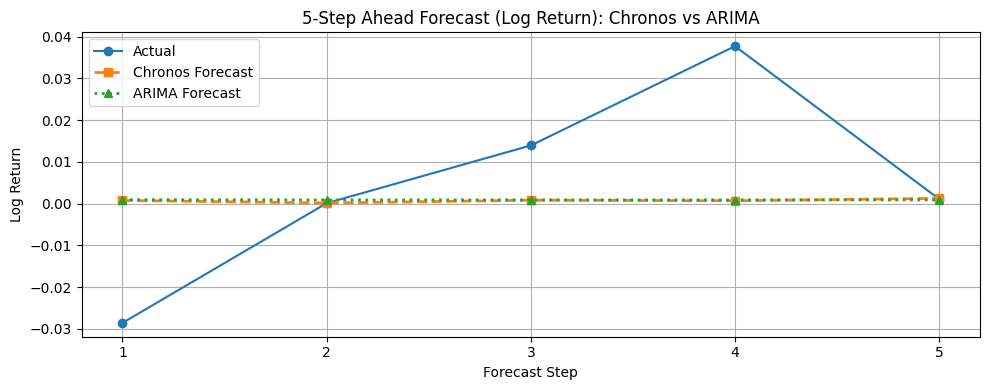

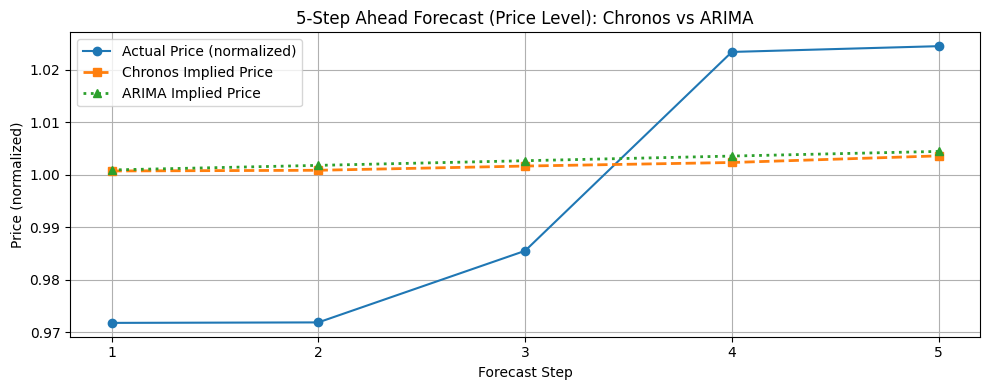

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# =====================================
# 0. How many forecast steps to show
# =====================================
H_SHOW = 300      # <-- change this to 5, 30, 60, 100, etc.

# ============================
# 1. Chronos multi-step prediction
# ============================

# Predict with Chronos on the short-horizon predictor
pred_5 = predictor_5.predict(test_5)

pred_5_pd = pred_5.copy()
test_5_pd = test_5.copy()

# Flatten MultiIndex (item_id, timestamp) into columns if needed
if isinstance(pred_5_pd.index, pd.MultiIndex):
    pred_5_pd = pred_5_pd.reset_index()
if isinstance(test_5_pd.index, pd.MultiIndex):
    test_5_pd = test_5_pd.reset_index()

# Assume there is a single series
series_id = test_5_pd["item_id"].unique()[0]

# Ground truth log-returns for the Chronos test part
y_true_full = (
    test_5_pd[test_5_pd["item_id"] == series_id]
    .sort_values("timestamp")
    .set_index("timestamp")["target"]
)

# Determine prediction column name for Chronos
if "mean" in pred_5_pd.columns:
    pred_col = "mean"
elif "target" in pred_5_pd.columns:
    pred_col = "target"
else:
    pred_col = [c for c in pred_5_pd.columns if c not in ["item_id", "timestamp"]][0]

y_pred_chronos_full = (
    pred_5_pd[pred_5_pd["item_id"] == series_id]
    .sort_values("timestamp")
    .set_index("timestamp")[pred_col]
)

print("Chronos y_true_full head:\n", y_true_full.head())
print("Chronos y_pred_chronos_full head:\n", y_pred_chronos_full.head())

# ============================
# 2. ARIMA multi-step forecast
# ============================

focus_ticker = series_id

train_series_plot = (
    train_df[train_df["ticker"] == focus_ticker]
    .sort_values("date")["log_return"]
    .dropna()
)

test_series_plot = (
    test_df[test_df["ticker"] == focus_ticker]
    .sort_values("date")["log_return"]
    .dropna()
)

print("Train length for ARIMA:", len(train_series_plot))
print("Test length for ARIMA :", len(test_series_plot))

# Fit ARIMA(p,d,q) (ARIMA_ORDER defined earlier)
model_plot = ARIMA(train_series_plot, order=ARIMA_ORDER)
model_fit_plot = model_plot.fit()

# ============================
# 3. Choose effective horizon
# ============================

max_steps = min(
    H_SHOW,
    len(y_true_full),
    len(y_pred_chronos_full),
    len(test_series_plot),
)
print(f"Will plot {max_steps} forecast steps.")

# Take the first max_steps from each series
y_true_steps    = y_true_full.iloc[:max_steps].values
y_chronos_steps = y_pred_chronos_full.iloc[:max_steps].values

fc_plot = model_fit_plot.forecast(steps=max_steps)
y_arima_steps = np.array(fc_plot)

# Build x-axis based on the actual length we got
steps = np.arange(1, len(y_true_steps) + 1)

print("len steps        =", len(steps))
print("len y_true_steps =", len(y_true_steps))
print("len y_chronos_steps =", len(y_chronos_steps))
print("len y_arima_steps   =", len(y_arima_steps))



# ===========================================
# 4. Plot: multi-step forecast (log-return)
# ===========================================

plt.figure(figsize=(10, 4))
plt.plot(steps, y_true_steps,
         label="Actual", marker="o", linewidth=1.5)
plt.plot(steps, y_chronos_steps,
         label="Chronos Forecast", marker="s", linestyle="--", linewidth=2.0)
plt.plot(steps, y_arima_steps,
         label="ARIMA Forecast", marker="^", linestyle=":", linewidth=2.0)
plt.title(f"{max_steps}-Step Ahead Forecast (Log Return): Chronos vs ARIMA")
plt.xlabel("Forecast Step")
plt.ylabel("Log Return")
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================================
# 5. Plot: multi-step forecast (price level)
# ===========================================

P0 = 1.0  # base price; can be replaced with a real starting price

cum_true    = np.cumsum(y_true_steps)
cum_chronos = np.cumsum(y_chronos_steps)
cum_arima   = np.cumsum(y_arima_steps)

price_true    = P0 * np.exp(cum_true)
price_chronos = P0 * np.exp(cum_chronos)
price_arima   = P0 * np.exp(cum_arima)

plt.figure(figsize=(10, 4))
plt.plot(steps, price_true,
         label="Actual Price (normalized)", marker="o", linewidth=1.5)
plt.plot(steps, price_chronos,
         label="Chronos Implied Price", marker="s", linestyle="--", linewidth=2.0)
plt.plot(steps, price_arima,
         label="ARIMA Implied Price", marker="^", linestyle=":", linewidth=2.0)
plt.title(f"{max_steps}-Step Ahead Forecast (Price Level): Chronos vs ARIMA")
plt.xlabel("Forecast Step")
plt.ylabel("Price (normalized)")
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Series id (60-step): AAPL
Chronos-60 y_true_full_60 length: 2850
Chronos-60 y_pred_chronos_full_60 length: 60
Train length for ARIMA (60): 2199
Test length for ARIMA (60) : 549
[60-step] Will plot 60 forecast steps.
len steps_60           = 60
len y_true_steps_60    = 60
len y_chronos_steps_60 = 60
len y_arima_steps_60   = 60


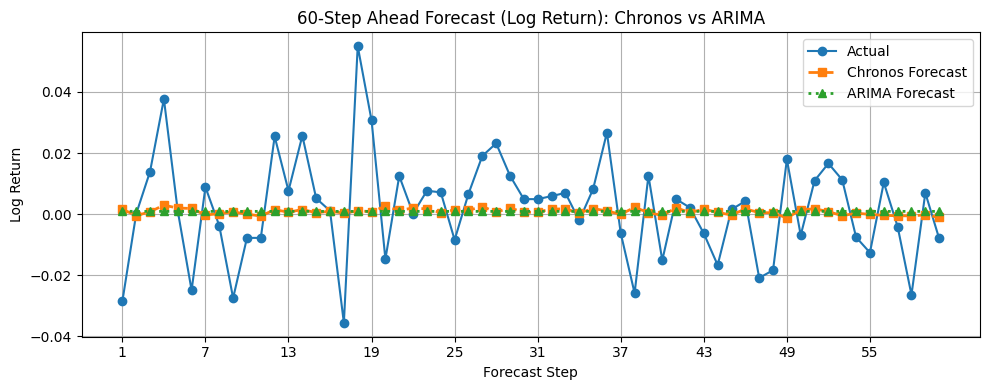

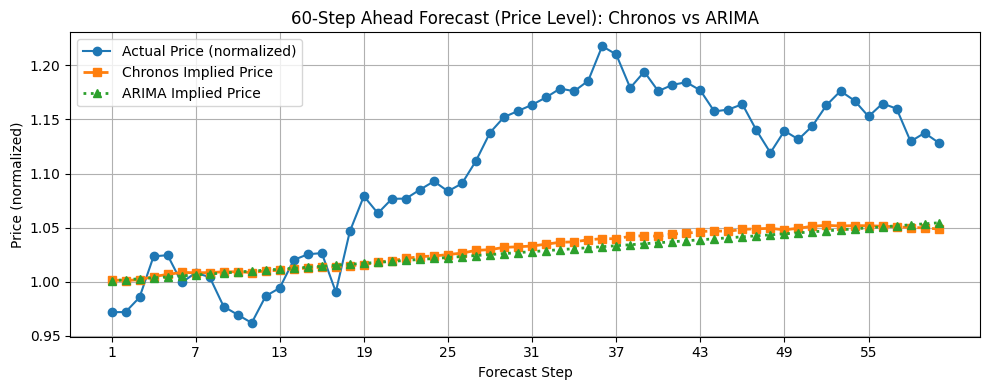

In [55]:
# =====================================
# 0. How many forecast steps to show
# =====================================
H_SHOW_60 = 60     # you can set this to 30, 60, etc.

# ============================
# 1. Chronos 60-step prediction
# ============================

# Predict with Chronos on the long-horizon predictor
pred_60 = predictor_60.predict(test_60)

pred_60_pd = pred_60.copy()
test_60_pd = test_60.copy()

# Flatten MultiIndex (item_id, timestamp) into columns if needed
if isinstance(pred_60_pd.index, pd.MultiIndex):
    pred_60_pd = pred_60_pd.reset_index()
if isinstance(test_60_pd.index, pd.MultiIndex):
    test_60_pd = test_60_pd.reset_index()

# Assume there is a single series
series_id_60 = test_60_pd["item_id"].unique()[0]
print("Series id (60-step):", series_id_60)

# Ground truth log-returns for the Chronos test part (60-day horizon)
y_true_full_60 = (
    test_60_pd[test_60_pd["item_id"] == series_id_60]
    .sort_values("timestamp")
    .set_index("timestamp")["target"]
)

# Determine prediction column name for Chronos (60-step)
if "mean" in pred_60_pd.columns:
    pred_col_60 = "mean"
elif "target" in pred_60_pd.columns:
    pred_col_60 = "target"
else:
    pred_col_60 = [c for c in pred_60_pd.columns if c not in ["item_id", "timestamp"]][0]

y_pred_chronos_full_60 = (
    pred_60_pd[pred_60_pd["item_id"] == series_id_60]
    .sort_values("timestamp")
    .set_index("timestamp")[pred_col_60]
)

print("Chronos-60 y_true_full_60 length:", len(y_true_full_60))
print("Chronos-60 y_pred_chronos_full_60 length:", len(y_pred_chronos_full_60))


# ============================
# 2. ARIMA 60-step forecast
# ============================

focus_ticker_60 = series_id_60  # keep consistent with Chronos

train_series_plot_60 = (
    train_df[train_df["ticker"] == focus_ticker_60]
    .sort_values("date")["log_return"]
    .dropna()
)

test_series_plot_60 = (
    test_df[test_df["ticker"] == focus_ticker_60]
    .sort_values("date")["log_return"]
    .dropna()
)

print("Train length for ARIMA (60):", len(train_series_plot_60))
print("Test length for ARIMA (60) :", len(test_series_plot_60))

# Fit ARIMA(p,d,q) (same ARIMA_ORDER as before)
model_plot_60 = ARIMA(train_series_plot_60, order=ARIMA_ORDER)
model_fit_plot_60 = model_plot_60.fit()


# ============================
# 3. Choose effective horizon
# ============================

max_steps_60 = min(
    H_SHOW_60,
    len(y_true_full_60),
    len(y_pred_chronos_full_60),
    60,                      # logical upper bound for this horizon
)

print(f"[60-step] Will plot {max_steps_60} forecast steps.")

# Chronos: first max_steps_60 from test horizon
y_true_steps_60    = y_true_full_60.iloc[:max_steps_60].values
y_chronos_steps_60 = y_pred_chronos_full_60.iloc[:max_steps_60].values

# ARIMA: max_steps_60-ahead forecast from the end of training
fc_plot_60 = model_fit_plot_60.forecast(steps=max_steps_60)
y_arima_steps_60 = np.array(fc_plot_60)

steps_60 = np.arange(1, max_steps_60 + 1)

print("len steps_60           =", len(steps_60))
print("len y_true_steps_60    =", len(y_true_steps_60))
print("len y_chronos_steps_60 =", len(y_chronos_steps_60))
print("len y_arima_steps_60   =", len(y_arima_steps_60))


# ===========================================
# 4. Plot: 60-step forecast (log-return)
# ===========================================

plt.figure(figsize=(10, 4))
plt.plot(steps_60, y_true_steps_60,
         label="Actual", marker="o", linewidth=1.5)
plt.plot(steps_60, y_chronos_steps_60,
         label="Chronos Forecast", marker="s", linestyle="--", linewidth=2.0)
plt.plot(steps_60, y_arima_steps_60,
         label="ARIMA Forecast", marker="^", linestyle=":", linewidth=2.0)
plt.title(f"{max_steps_60}-Step Ahead Forecast (Log Return): Chronos vs ARIMA")
plt.xlabel("Forecast Step")
plt.ylabel("Log Return")
plt.xticks(steps_60[::max(1, max_steps_60 // 10)])  # avoid too many x-ticks
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ===========================================
# 5. Plot: 60-step forecast (price level)
# ===========================================

P0_60 = 1.0  # base price; can be replaced with a real starting price

cum_true_60    = np.cumsum(y_true_steps_60)
cum_chronos_60 = np.cumsum(y_chronos_steps_60)
cum_arima_60   = np.cumsum(y_arima_steps_60)

price_true_60    = P0_60 * np.exp(cum_true_60)
price_chronos_60 = P0_60 * np.exp(cum_chronos_60)
price_arima_60   = P0_60 * np.exp(cum_arima_60)

plt.figure(figsize=(10, 4))
plt.plot(steps_60, price_true_60,
         label="Actual Price (normalized)", marker="o", linewidth=1.5)
plt.plot(steps_60, price_chronos_60,
         label="Chronos Implied Price", marker="s", linestyle="--", linewidth=2.0)
plt.plot(steps_60, price_arima_60,
         label="ARIMA Implied Price", marker="^", linestyle=":", linewidth=2.0)
plt.title(f"{max_steps_60}-Step Ahead Forecast (Price Level): Chronos vs ARIMA")
plt.xlabel("Forecast Step")
plt.ylabel("Price (normalized)")
plt.xticks(steps_60[::max(1, max_steps_60 // 10)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


AutoGluon 5d errors: 250
ARIMA 5d errors: 5


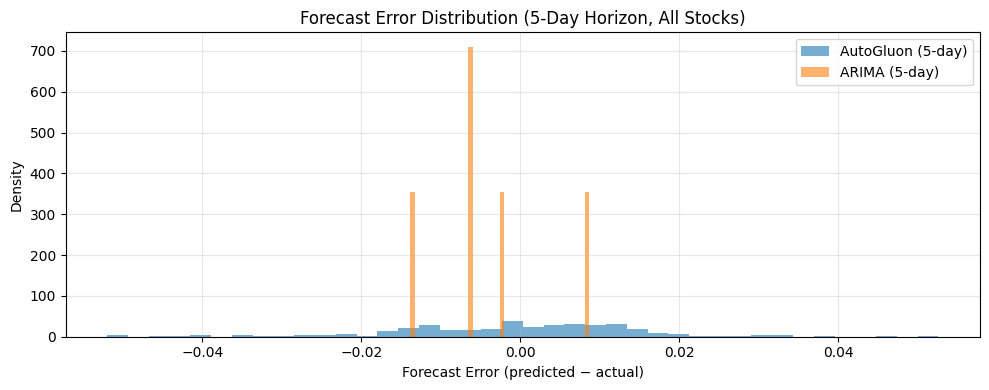

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


AutoGluon 60d errors: 3000
ARIMA 60d errors: 60


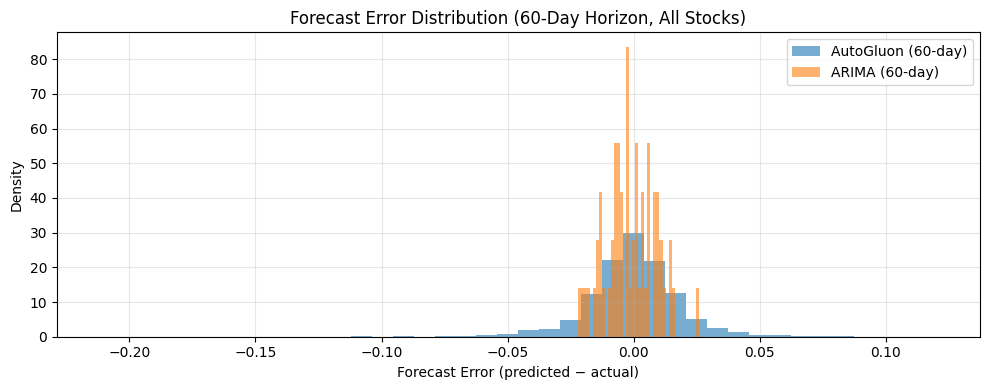

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# 1. AutoGluon: 5-day forecast errors (all series)
# ==========================================


pred_5_AG = predictor_5.predict(train_5)      
df_pred_5_AG = pred_5_AG.to_data_frame()
df_true_5_AG = test_5.to_data_frame()

y_pred_5_AG = df_pred_5_AG["mean"]
y_true_5_AG = df_true_5_AG["target"]


y_true_5_AG_algn, y_pred_5_AG_algn = y_true_5_AG.align(y_pred_5_AG, join="inner")
err_5_AG = (y_pred_5_AG_algn - y_true_5_AG_algn).dropna()

print("AutoGluon 5d errors:", len(err_5_AG))


# ==========================================
# 2. ARIMA: 5-day forecast errors (all series)
# ==========================================

arima_5_all = arima_detail_df[arima_detail_df["horizon"] == "5d"].copy()
err_5_ARIMA = (arima_5_all["y_pred"] - arima_5_all["y_true"]).dropna()

print("ARIMA 5d errors:", len(err_5_ARIMA))


# ==========================================
# 3. Plot: 5-day error distribution
# ==========================================

plt.figure(figsize=(10,4))
plt.hist(err_5_AG, bins=40, alpha=0.6, density=True,
         label="AutoGluon (5-day)")
plt.hist(err_5_ARIMA, bins=40, alpha=0.6, density=True,
         label="ARIMA (5-day)")

plt.title("Forecast Error Distribution (5-Day Horizon, All Stocks)")
plt.xlabel("Forecast Error (predicted − actual)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ==========================================
# 4. AutoGluon: 60-day forecast errors (all series)
# ==========================================

pred_60_AG = predictor_60.predict(train_60)
df_pred_60_AG = pred_60_AG.to_data_frame()
df_true_60_AG = test_60.to_data_frame()

y_pred_60_AG = df_pred_60_AG["mean"]
y_true_60_AG = df_true_60_AG["target"]

y_true_60_AG_algn, y_pred_60_AG_algn = y_true_60_AG.align(y_pred_60_AG, join="inner")
err_60_AG = (y_pred_60_AG_algn - y_true_60_AG_algn).dropna()

print("AutoGluon 60d errors:", len(err_60_AG))


# ==========================================
# 5. ARIMA: 60-day forecast errors (all series)
# ==========================================

arima_60_all = arima_detail_df[arima_detail_df["horizon"] == "60d"].copy()
err_60_ARIMA = (arima_60_all["y_pred"] - arima_60_all["y_true"]).dropna()

print("ARIMA 60d errors:", len(err_60_ARIMA))


# ==========================================
# 6. Plot: 60-day error distribution
# ==========================================

plt.figure(figsize=(10,4))
plt.hist(err_60_AG, bins=40, alpha=0.6, density=True,
         label="AutoGluon (60-day)")
plt.hist(err_60_ARIMA, bins=40, alpha=0.6, density=True,
         label="ARIMA (60-day)")

plt.title("Forecast Error Distribution (60-Day Horizon, All Stocks)")
plt.xlabel("Forecast Error (predicted − actual)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


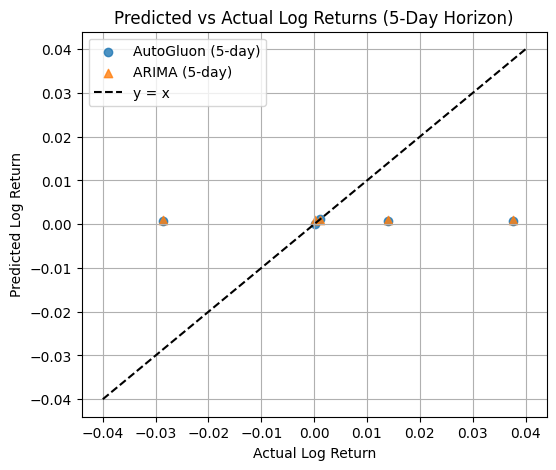

In [67]:
# ===== Actual values =====
y_true_5 = np.array(y_true_steps)   # actual 5-step returns from earlier code

# ===== AutoGluon =====
y_pred_5_ag = np.array(y_chronos_steps)

# ===== ARIMA =====
y_pred_5_arima = np.array(y_arima_steps)

# Make sure lengths match
k = min(len(y_true_5), len(y_pred_5_ag), len(y_pred_5_arima))

y_true_5 = y_true_5[:k]
y_pred_5_ag = y_pred_5_ag[:k]
y_pred_5_arima = y_pred_5_arima[:k]

plt.figure(figsize=(6,5))
plt.scatter(y_true_5, y_pred_5_ag, label="AutoGluon (5-day)", alpha=0.8)
plt.scatter(y_true_5, y_pred_5_arima, label="ARIMA (5-day)", alpha=0.8, marker="^")
plt.plot([-0.04, 0.04], [-0.04, 0.04], "k--", label="y = x")

plt.title("Predicted vs Actual Log Returns (5-Day Horizon)")
plt.xlabel("Actual Log Return")
plt.ylabel("Predicted Log Return")
plt.legend()
plt.grid(True)
plt.show()


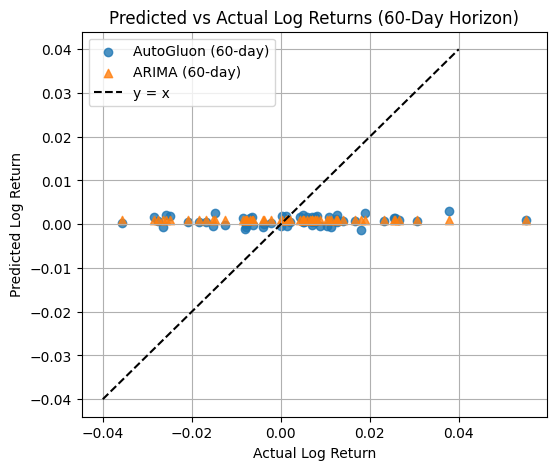

In [68]:
y_true_60 = np.array(y_true_steps_60)
y_pred_60_ag = np.array(y_chronos_steps_60)
y_pred_60_arima = np.array(y_arima_steps_60)

k = min(len(y_true_60), len(y_pred_60_ag), len(y_pred_60_arima))

y_true_60 = y_true_60[:k]
y_pred_60_ag = y_pred_60_ag[:k]
y_pred_60_arima = y_pred_60_arima[:k]

plt.figure(figsize=(6,5))
plt.scatter(y_true_60, y_pred_60_ag, label="AutoGluon (60-day)", alpha=0.8)
plt.scatter(y_true_60, y_pred_60_arima, label="ARIMA (60-day)", alpha=0.8, marker="^")
plt.plot([-0.04, 0.04], [-0.04, 0.04], "k--", label="y = x")

plt.title("Predicted vs Actual Log Returns (60-Day Horizon)")
plt.xlabel("Actual Log Return")
plt.ylabel("Predicted Log Return")
plt.legend()
plt.grid(True)
plt.show()
